# Angular Rate Control

The attitude rate controller is the most inner loop in ordinary quadrocopter flight
control codes. It operates on the attitude rate vector in the body reference system.

We implement three independent PID for each axis ($x$, $y$, $z$) loops with the following structure:

![AngularRate.drawio.svg](AngularRate.drawio.svg)

This is similiar to the px4 AngularRate controller. There are some notable differences compared to the textbook version of PIDs:

 * Only the measured state is used for the differential path, to prevent impulse responses in the output signal due to steps in the reference signal (also known as derivative kick)
 * The differentiated measurement is low pass filtered to reduce the effect of hight frequent noise
 * On the integral path additional information is fed in, to prevent integral windup

In [75]:
from enum import Enum
class RateConroller:
    Saturation = Enum("Saturation", "POSITIVE NONE NEGATIVE")
        
    def __init__(self, p, i, d, dt, i_lim=None):
        self._k_p = p
        self._k_i = i
        self._k_d = d
        
        self._dt = dt
        
        self._p_val = 0.0
        self._i_val = 0.0
        self._d_val = 0.0
        
        self._i_lower_lim = -i_lim
        self._i_upper_lim = i_lim
        self._i_sum = 0.0
        
        self._last_measurement = None
        self._saturation = self.Saturation.NONE     
        
    def _clip(self, val, upper_lim, lower_lim):
        assert (upper_lim is None or lower_lim is None) or upper_lim > lower_lim, \
            "The upper limit has always to be greater than the lower limit"
        if upper_lim is not None and val > upper_lim:
            return upper_lim
        elif lower_lim is not None and val < lower_lim:
            return lower_lim
        else:
            return val
    
    def _update_integrator(self, error, dt):
        
        if self._saturation is self.Saturation.POSITIVE:
            error = min(0.0, error)
        elif self._saturation is self.Saturation.NEGATIVE:
            error = max(0.0, error)
        
        self._i_sum += error * dt
        
        self._i_sum = self._clip(self._i_sum, self._i_upper_lim, self._i_lower_lim)
        
        return self._i_sum * self._k_i
    
    def _calc_d(self, measurement, dt):
        
        if self._last_measurement is not None:
            Δy = measurement - self._last_measurement
            
        else:
            Δy = 0.0
        
        self._last_measurement = measurement
        
        # TODO at Low Pass Filter
        
        return Δy
    
    def update(self, setpoint, measurement, dt=None):
        if dt is None:
            dt = self._dt
            
        error = setpoint - measurement
        
        self._p_val = error * self._k_p
        self._i_val = self._i_sum * self._k_i
        self._d_val = self._calc_d(measurement, dt) * self._k_d
        
        self._update_integrator(error, dt)
        
        return self._p_val  + self._i_val + self._d_val 
    
    def anti_windup_backcalculation(self, desired_output):
        self._i_sum = ( desired_output - self._p_val - self._d_val ) / self._k_i
        
    def set_saturation_state(self, saturation):
        self._saturation = saturation
        

# Trivial Test

In [76]:
import numpy as np

def Simulation(initial: float):
    
    value = initial
    
    def simulate(command: float, dt: float, doprint: bool = False):
        
        nonlocal value
        
        while dt > 0.0:
            value += 0.2 * command * dt
            
            if doprint:
                print(f"CMD: {command}, Value: {value}")
            
            return value
    
    return simulate

In [102]:
dt = 0.1
sim = Simulation(0.0)
pid = RateConroller(20., 1.0, 0.2, 0.01, 15.0)
cmd = 0.0

data = []

for i in range(3000):
    measurement = sim(cmd, dt)
    
    if i < 750:
        target = 0.0
    elif i < 1000:
        target = 1.0
    elif i < 1500:
        target = -1.0
    elif i < 2000:
        target = (i-1500) / 500.0 - 1.0
    else:
        target = 2.0
    
    cmd = pid.update(target, measurement, dt)
    
    data.append((measurement, target, cmd))
    

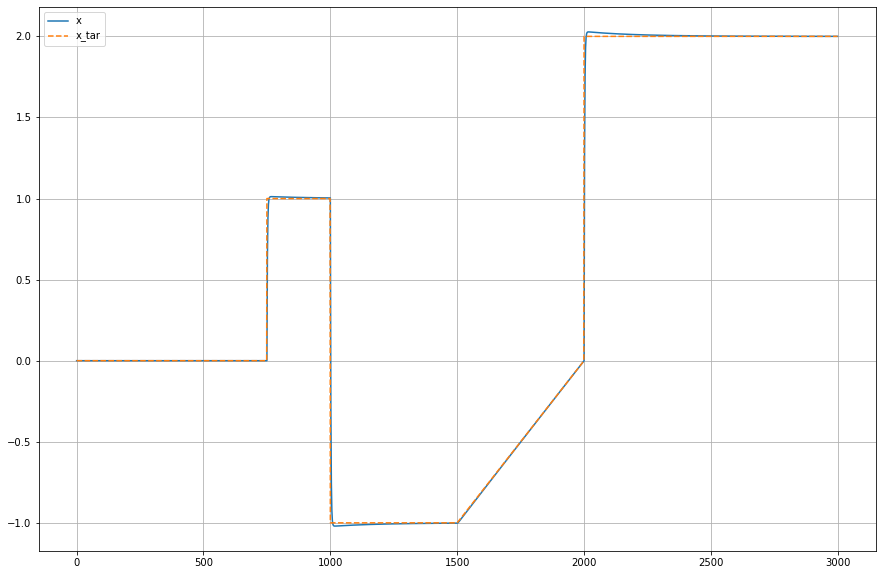

In [103]:
%matplotlib inline
from matplotlib import pyplot as plt

data = np.array(data)

plt.figure(figsize=(15,10))

plt.plot(data[:,0], label='x')
plt.plot(data[:,1], '--', label='x_tar')

plt.grid()
plt.legend()